In [9]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)


In [10]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 10, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

Epoch 1/1
23/23 [==============================] - 0s 20ms/step - loss: 0.2516
Epoch 1/1
23/23 [==============================] - 0s 905us/step - loss: 0.2482
Epoch 1/1
23/23 [==============================] - 0s 993us/step - loss: 0.2454
Epoch 1/1
23/23 [==============================] - 0s 1ms/step - loss: 0.2426
Epoch 1/1
23/23 [==============================] - 0s 940us/step - loss: 0.2398
Epoch 1/1
23/23 [==============================] - 0s 1ms/step - loss: 0.2372
Epoch 1/1
23/23 [==============================] - 0s 938us/step - loss: 0.2345
Epoch 1/1
23/23 [==============================] - 0s 1ms/step - loss: 0.2318
Epoch 1/1
23/23 [==============================] - 0s 918us/step - loss: 0.2292
Epoch 1/1
23/23 [==============================] - 0s 1ms/step - loss: 0.2265


array([[-0.031665  ],
       [ 0.02454917],
       [-0.05464059],
       [-0.04562951],
       [-0.10418026],
       [-0.09858857],
       [-0.12266855],
       [-0.10033815],
       [-0.0760432 ],
       [-0.05158804],
       [-0.12657969],
       [-0.02137586],
       [-0.07087551],
       [-0.07117635],
       [-0.11854331],
       [-0.13546221],
       [-0.06926166],
       [-0.11688609],
       [-0.07016684],
       [-0.10943682],
       [-0.08782062],
       [-0.12461672],
       [-0.00393257]], dtype=float32)

Month=1, Predicted=352.314713, Expected=339.700000
Month=2, Predicted=352.981904, Expected=440.400000
Month=3, Predicted=428.814948, Expected=315.900000
Month=4, Predicted=350.326074, Expected=439.300000
Month=5, Predicted=436.833414, Expected=401.300000
Month=6, Predicted=416.106039, Expected=437.400000
Month=7, Predicted=443.156726, Expected=575.500000
Month=8, Predicted=550.961973, Expected=407.600000
Month=9, Predicted=444.815093, Expected=682.000000
Month=10, Predicted=659.626294, Expected=475.300000
Month=11, Predicted=522.789371, Expected=581.300000
Month=12, Predicted=591.268834, Expected=646.900000
Test RMSE: 117.261


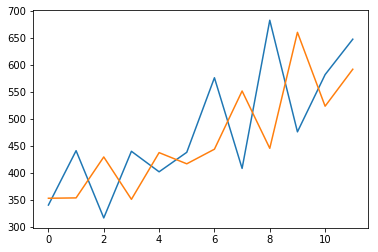

In [8]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()